In [1]:
#on importe les librairies necessaires
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import spacy
import numpy as np

In [2]:
#on charge le dataset puis on affiche
multilingual_dset= pd.read_csv("data/multilingual_dataset.csv")
multilingual_dset

,texts,lg
0,As much as I wanted to love the box it came br...,en
1,The app opens and immediately crashes. Can't w...,en
2,"Mal producto. Una caída desde 50 cm, y la fund...",es
3,"Sieht ganz gut aus,ist schlecht zu montieren u...",de
4,I needed this for a project. The scroll came w...,en
...,...,...
39995,Je suis extrêmement déçue par cet achat. Je co...,fr
39996,Ich bin geschockt habe 3 Kinder aber sowas ist...,de
39997,El producto no llegué a recibirlo. Después de ...,es
39998,This board could have been a perfect board for...,en


In [4]:
#on affiche les informations sur le dataset
multilingual_dset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   40000 non-null  object
 1   lg      40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


<Axes: xlabel='lg'>

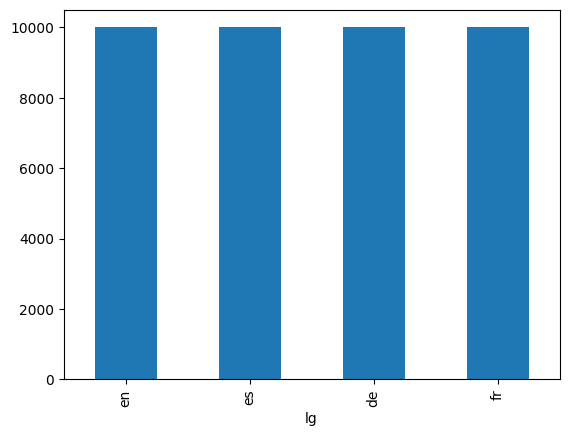

In [5]:
#on vizualise les classes 
multilingual_dset["lg"].value_counts().plot.bar()

On voit que notre dataset contient 4 classes et elles sont toutes équilibrées 

In [3]:
#on sépare les textes et les langues(les labels)
x= multilingual_dset["texts"]
y= multilingual_dset["lg"]

#on divise le dataset en train, dev et test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.70, random_state= 40)

x_dev, x_test, y_dev, y_test = train_test_split(x_temp, y_temp, train_size=0.5, random_state= 42)

print("train:", x_train.shape, y_train.shape)
print("dev:", x_dev.shape, y_dev.shape)
print("test:", x_test.shape, y_test.shape)

train: (28000,) (28000,)
dev: (6000,) (6000,)
test: (6000,) (6000,)


In [4]:
#on charge le modèle word2vec pré-entrainé le les textes de notre dataset reviews_en
model = Word2Vec.load("data/reviews_en_model.w2v", mmap="r")

In [5]:
#on charge le modèle anglais spacy pour tokeniser les textes
nlp= spacy.load("en_core_web_md")

In [6]:
#on encode les textes en utilisant le modèle word2vec 
def encode_sentence(text, nlp, we_model): #on définit une fonction qui prend en entrée un texte, un modèle spacy et un modèle word2vec
    doc = nlp(text)#
    tok_sent = [str(tok.text) for tok in doc]#on tokenise le texte
    return we_model.wv.get_mean_vector(tok_sent) #on retourne le vecteur moyen des vecteurs des mots du texte
encoded_x_train = np.array([
    encode_sentence(str(text), nlp=nlp, we_model=model)#on encode les textes du train
    for text in x_train
]) #on retourne un tableau numpy contenant les vecteurs des textes du train


In [7]:
print(encoded_x_train.shape)

(28000, 100)


In [8]:
#on encode x_dev et x_test aussi

encoded_x_dev = np.array([encode_sentence(x, nlp=nlp, we_model=model) for x in x_dev])

encoded_x_test = np.array([encode_sentence(x, nlp=nlp, we_model=model) for x in x_test])

print(encoded_x_dev.shape, encoded_x_test.shape)

(6000, 100) (6000, 100)


In [ ]:
from sklearn.preprocessing import LabelEncoder
#on crée une instance
label_encoder= LabelEncoder()

#fit_transform() permet d'apprendre les paramètres de transformation à partir des données d'entraînement et de les appliquer immédiatement
y_train_enco= label_encoder.fit_transform(y_train)
print(y_train_enco)

y_dev_enco= label_encoder.transform(y_dev)
print(y_dev_enco)

y_test_enco= label_encoder.transform(y_test)
print(y_test_enco)

[3 0 1 ... 2 2 1]
[1 2 3 ... 0 0 0]
[3 2 1 ... 1 2 1]


In [10]:
#label_encoder.classes_ permet de retourner les classes de la variable cible
label_encoder.classes_

array(['de', 'en', 'es', 'fr'], dtype=object)

In [11]:
#on crée un dictionnaire qui contient les classes et leur index
classe_maping= {}
for i, classe in enumerate(label_encoder.classes_):
    classe_maping[i]= classe
    classe_maping[classe]= i
classe_maping

{0: 'de', 'de': 0, 1: 'en', 'en': 1, 2: 'es', 'es': 2, 3: 'fr', 'fr': 3}

In [ ]:
#on importe le modèle KNN pour la classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
#instantier le model en définissant K
knn_model_v1 = KNeighborsClassifier(n_neighbors=3)#on crée une instance du modèle KNN en définissant K=3
knn_model_v1 #on affiche les paramètres du modèle

KNeighborsClassifier(n_neighbors=3)

In [13]:
#on entraine le modèle
knn_model_v1.fit(encoded_x_train, y_train_enco)

KNeighborsClassifier(n_neighbors=3)

In [14]:
#on valide le model
encoded_x_dev_val= knn_model_v1.predict(encoded_x_dev)
print(classification_report(y_dev_enco, encoded_x_dev_val))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1522
           1       0.93      0.94      0.94      1535
           2       0.96      0.83      0.89      1492
           3       0.88      0.84      0.86      1451

    accuracy                           0.89      6000
   macro avg       0.90      0.89      0.89      6000
weighted avg       0.90      0.89      0.89      6000



In [15]:
#on teste le model
encoded_x_test_t = knn_model_v1.predict(encoded_x_test)
print(classification_report(y_test_enco, encoded_x_test_t))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1466
           1       0.94      0.94      0.94      1497
           2       0.95      0.84      0.89      1508
           3       0.88      0.82      0.85      1529

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



In [16]:
#on sauvegarde les résultats du modèle avec la métrique f1_score
results= {}
results["model_knn"]= float(f1_score(y_test_enco, encoded_x_test_t, average="weighted"))

on entraine aussi un modèle de LogisticRegression avec les meme données.

In [18]:
#on importe le modèle de régression logistique
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score #on importe les métriques de classification et f1_score

lr_model_v1= LogisticRegression()#on crée une instance du modèle de régression logistique

In [19]:
lr_model_v1.fit(encoded_x_train, y_train_enco) #on entraine le modèle

c:\Users\mouha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
lr_model_v1_d= lr_model_v1.predict(encoded_x_dev)#on valide le modèle
print(classification_report(y_dev_enco, lr_model_v1_d))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1522
           1       0.72      0.92      0.81      1535
           2       0.94      0.80      0.86      1492
           3       0.86      0.71      0.77      1451

    accuracy                           0.81      6000
   macro avg       0.82      0.81      0.81      6000
weighted avg       0.82      0.81      0.81      6000



In [22]:
lr_model_v1_t= lr_model_v1.predict(encoded_x_test)#on teste le modèle
print(classification_report(y_test_enco, lr_model_v1_t))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1466
           1       0.72      0.92      0.81      1497
           2       0.95      0.81      0.88      1508
           3       0.88      0.71      0.79      1529

    accuracy                           0.81      6000
   macro avg       0.82      0.81      0.81      6000
weighted avg       0.82      0.81      0.81      6000



In [23]:
#on sauvegarde le résultat du modèle avec la métrique f1_score
results["model_rl"]= float(f1_score(y_test_enco, lr_model_v1_t, average= "weighted"))

Nous procédons au chargement des modèles afin d'effectuer une analyse comparative à l'aide de matplotlib.

model_knn 0.8859486207764375
model_rl 0.8093085085626571
{'model_knn': 0.8859486207764375, 'model_rl': 0.8093085085626571}


<Axes: >

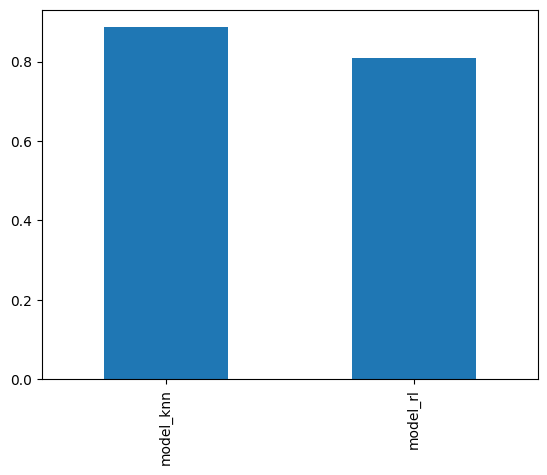

In [ ]:
for k, v in results.items(): 
    print(k,v)
    
print(results)
viz = pd.Series(results)
viz.plot.bar()

***Analyse de resultats***


Après analyse des résultats des deux modèles testés, nous observons une nette différence de performance en faveur du modèle model_Knn. Ce dernier atteint un score de performance d'environ 88.6%, tandis que le model_rl affiche un score de 80.9%. L'écart significatif de 7.7 points de pourcentage entre les deux modèles suggère que le KNN est particulièrement bien adapté à la structure de nos données. Cette supériorité du KNN peut s'expliquer par sa capacité à capturer des relations non linéaires dans les données, contrairement à la régression logistique qui repose sur une approche linéaire. La régression logistique, bien qu'offrant une performance correcte, semble moins appropriée pour ce cas d'usage spécifique. Ces résultats indiquent clairement que le Knn est le choix le plus judicieux pour une problématique de classification de produit.